In [1]:
import re
import warnings
warnings.filterwarnings("ignore")


import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import matplotlib.transforms as transforms

import seaborn as sns

from scipy.ndimage.filters import gaussian_filter1d
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA #мультфакторная анова
from statsmodels.formula.api import ols #линейные модели 

from scipy.stats import f_oneway as ANOVA

import scipy


![alt text](map.jpg "Схема GPS")

# Агрохимия 

In [2]:
agrochemistry_total = pd.read_csv('полевые данные общая/ready_data/агрохимия.csv')
agrochemistry_total["Год"] = agrochemistry_total["Год"].astype(str)
agrochemistry_total["GPS №"] = agrochemistry_total["GPS №"].astype(str)
agrochemistry_total.columns

Index(['Год', 'GPS №', 'Тип обработки', 'Глубина', 'повторность',
       'рН солевой вытяжки, ед. рН', 'рН водной вытяжки, ед. рН',
       'Фосфор (подвижная форма), мг/кг', 'Калий (подвижная форма), млн-1',
       'Общий азот, %', 'Общий углерод, %',
       'М.д. содержания  гипса (по Хитрову), %',
       'Массовая доля иона хлорида, ммоль/100 г',
       'Массовая доля иона сульфата, ммоль/100 г',
       'Массовая доля магния (водорастворимая форма), ммоль/100 г почвы',
       'Массовая доля кальция (водорастворимая форма), ммоль/100 г почвы',
       'Массовая доля натрия (водорастворимая форма), мг•экв на 100 г почвы',
       'Массовая доля калия (водорастворимая форма), мг•экв на 100 г почвы',
       'Сумма поглощенных оснований по Каппену, ммоль/100 г',
       'Массовая доля плотного остатка водной вытяжки, %',
       'Карбонат и бикарбонат-ионы, ммоль/100 г',
       'Массовая доля общего содержания карбонатов (по Козловскому), % (CO2)',
       'Массовая доля общего содержания карб

### Агрохимические показатели по пахатному горизонту

In [3]:
agrochem_columns = ['Год', 'GPS №', 'Тип обработки', 'Глубина', 'повторность',
       'рН солевой вытяжки, ед. рН', 'рН водной вытяжки, ед. рН',
       'Фосфор (подвижная форма), мг/кг', 'Калий (подвижная форма), млн-1',
       'Общий азот, %', 'Органический углерод, %']


agrochemistry_main = agrochemistry_total[agrochemistry_total['Глубина'].isin(['0-10',"10-20","20-30"])][agrochem_columns]
agrochemistry_main['GPS №'] = agrochemistry_main['GPS №'].astype(int)
agrochemistry_main.drop('повторность', axis = 1, inplace= True)
agrochemistry_main.dropna(axis = 0, inplace= True)





In [12]:
len(agrochemistry_main['GPS №'].unique()) - 8 + (8 * 4)

46

In [ ]:

def aov_for_nominal(df, agrochem_property):
    """
    input - dataframe by agrochemical_proprerty
    output - resul of MANOVA
    """
    dispers = df.copy()
    agrochem_property_ = re.sub(r'[\(),.%№ /-]', '' , agrochem_property)
    dispers.columns = dispers.columns.str.replace(r'[\(),.%№ /-]', '', )
    reg = ols('{} ~ Год + Глубина  +  Типобработки + GPS'.format(agrochem_property_) ,  data=dispers).fit()
    aov = sm.stats.anova_lm(reg)
    aov = aov[["PR(>F)"]]
    aov.columns = ['p-value']
    aov = aov.iloc[:4,:]
    aov['p-value'] = round(aov['p-value'] , 3)
    return aov

def anova(df, varible, agrochem_property):
    stat_test_df = pd.DataFrame()
    for ind,depth in enumerate(df["Глубина"].unique()): 
        df_by_depth = df[df["Глубина"] == depth]
        sample_list = []
        for value  in df[varible].unique():
            sample = df_by_depth[agrochem_property][df[varible] == value].values
            sample_list.append(sample) 
        
        p_val = ANOVA(*sample_list)[1]
        local_df = pd.DataFrame({"глубина":depth, 'p-value' : p_val}, index = [ind])
        stat_test_df = stat_test_df.append(local_df)
    stat_test_df["p-value"] = round(stat_test_df["p-value"],3)
    return(stat_test_df)
    
def ploting( df, hue,  agrochem_property , aov ,stat_test_df, to_lable = "по обработкам" ):
    fig = plt.figure(figsize=(7,7))
    ax1 = plt.subplot2grid((3,2), (0, 0), colspan=2, rowspan = 2)
    ax2 = plt.subplot2grid((3,2), (2, 0))
    ax3 = plt.subplot2grid((3,2), (2, 1))
    if len(df[hue].unique()) == 2:
        pal =  "prism_r"
    else:
        pal =  "tab10"
    sns.pointplot(data = df,
        x = "Глубина",
        y = agrochem_property,
        hue = hue,
        palette = pal,
        scale = 1.2,
        ci = 95,
        dodge= 0.5,
        join = False,
        capsize = .05,
        ax = ax1)
    ax1.set_title('Сравнение по {}'.format(to_lable))

    ax2.axis('off')
    ax2.axis('tight')
    ax2.table(aov.values,rowLabels=aov.index , colLabels = aov.columns ,loc='center')
    ax2.set_title('Дисперсионный анализ \nпо {} (MANOVA)'.format(to_lable),  y=0.75 , x = 0.5)

    ax3.axis('off')
    ax3.axis('tight')
    ax3.table(stat_test_df.values, colLabels = stat_test_df.columns ,loc='center')
    ax3.set_title('Сравнение выборок \nпо {} (ANOVA)'.format(to_lable),  y=0.75 , x = 0.5)
    plt.show(block=True)
    return fig 

def data_processing(df, type_ , agrochem_property , to_lable = "1", fizika = None ):
    stats_type = df.groupby([type_,'Глубина']).agg({ np.mean,  np.std, scipy.stats.variation})
    if fizika == None:
        features = ['Год', 'GPS №', 'Тип обработки', 'Глубина']
    else:
        features = ['GPS №']
    features.append(agrochem_property) #добавление фичи
    df = df[features]
    stats = df.groupby([type_,'Глубина']).agg({ np.mean,  np.std, scipy.stats.variation})

    aov = aov_for_nominal(df, agrochem_property)
    stat_test_df = anova(df, type_, agrochem_property)
    fig = ploting(df, type_, agrochem_property, aov,stat_test_df,to_lable  )

    return(stats , aov, stat_test_df,fig )


#### отобрали данные

описательные статистики

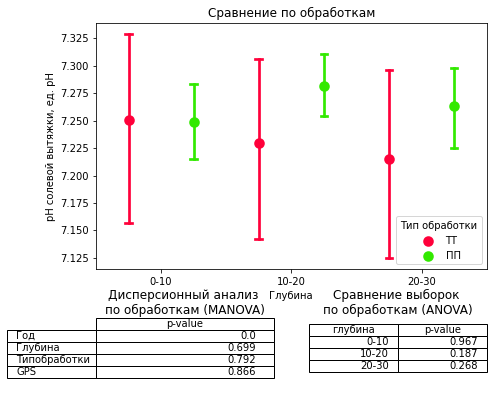

In [ ]:
_,_,_ ,fig = data_processing(df = agrochemistry_main, type_ = 'Тип обработки', agrochem_property = 'рН солевой вытяжки, ед. рН', to_lable = "обработкам")

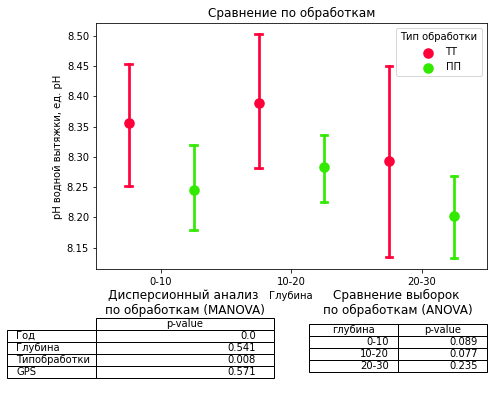

In [6]:
_,_,_ ,fig = data_processing(df = agrochemistry_main, type_ = 'Тип обработки', agrochem_property = 'рН водной вытяжки, ед. рН', to_lable = "обработкам")

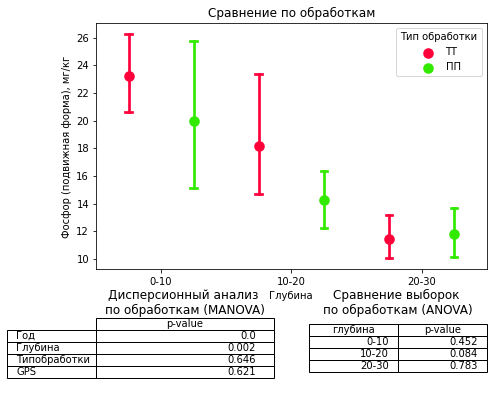

In [7]:
_,_,_ ,fig = data_processing(df = agrochemistry_main, type_ = 'Тип обработки', agrochem_property = 'Фосфор (подвижная форма), мг/кг', to_lable = "обработкам")

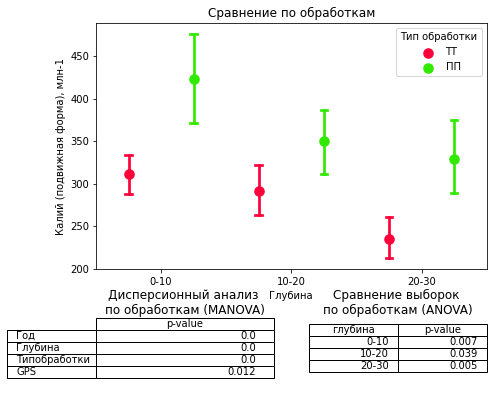

In [8]:
_,_,_ ,fig = data_processing(df = agrochemistry_main, type_ = 'Тип обработки', agrochem_property = 'Калий (подвижная форма), млн-1', to_lable = "обработкам")

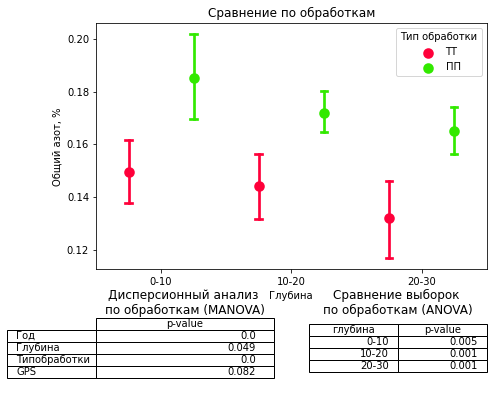

In [9]:
_,_,_ ,fig = data_processing(df = agrochemistry_main, type_ = 'Тип обработки', agrochem_property = 'Общий азот, %', to_lable = "обработкам")

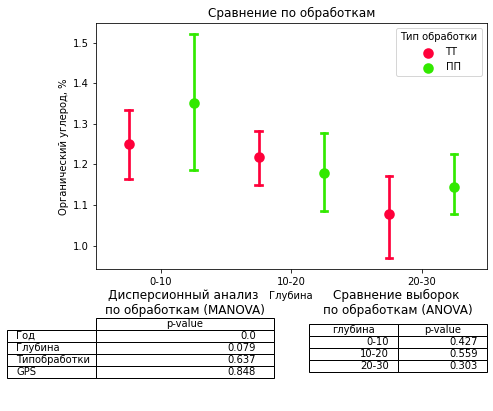

In [10]:
_,_,_ ,fig = data_processing(df = agrochemistry_main, type_ = 'Тип обработки', agrochem_property = 'Органический углерод, %', to_lable = "обработкам")

In [11]:
pp_points = [525,526,527,528,586]
by_points = agrochemistry_main[agrochemistry_main["GPS №"].isin(pp_points)]

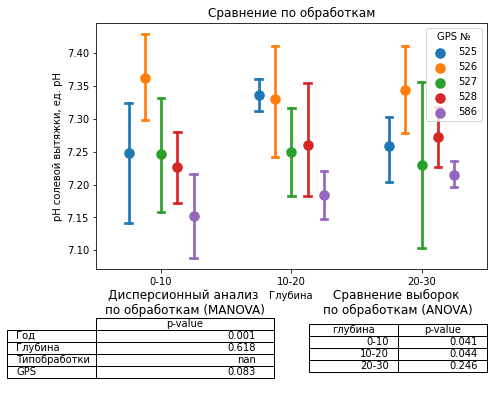

In [12]:
_,_,_ ,fig = data_processing(df = by_points, type_ = "GPS №", agrochem_property = 'рН солевой вытяжки, ед. рН', to_lable = "обработкам")

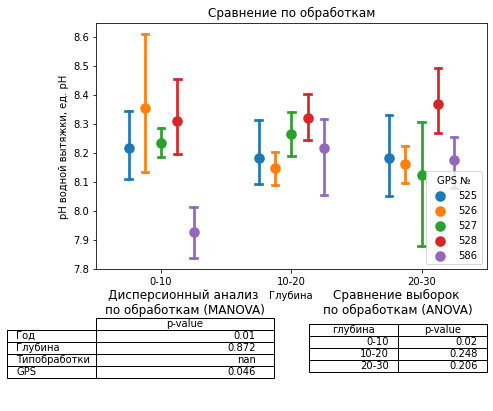

In [13]:
_,_,_ ,fig = data_processing(df = by_points, type_ = "GPS №", agrochem_property = 'рН водной вытяжки, ед. рН', to_lable = "обработкам")

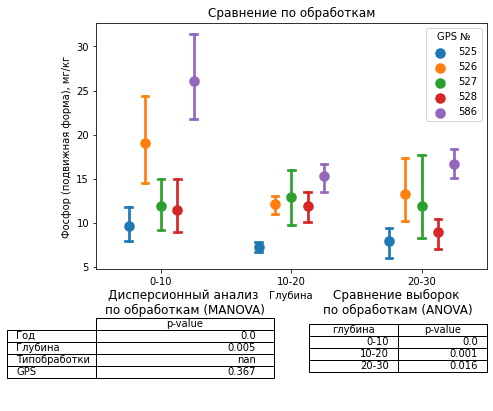

In [14]:
_,_,_ ,fig = data_processing(df = by_points, type_ = "GPS №", agrochem_property = 'Фосфор (подвижная форма), мг/кг', to_lable = "обработкам")

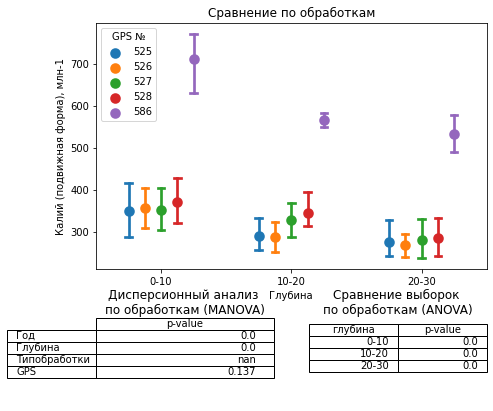

In [15]:
_,_,_ ,fig = data_processing(df = by_points, type_ = "GPS №", agrochem_property = 'Калий (подвижная форма), млн-1', to_lable = "обработкам")

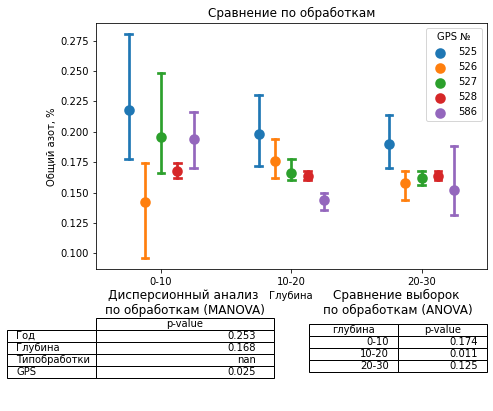

In [16]:
_,_,_ ,fig = data_processing(df = by_points, type_ = "GPS №", agrochem_property = 'Общий азот, %', to_lable = "обработкам")

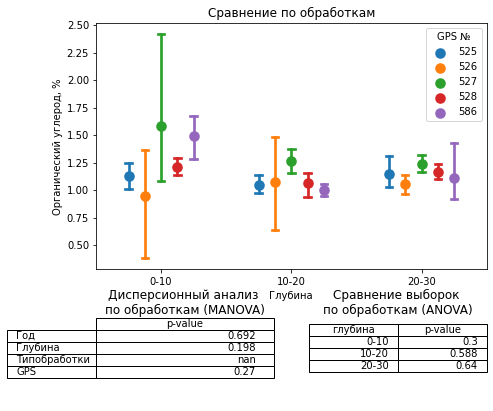

In [17]:
_,_,_ ,fig = data_processing(df = by_points, type_ = "GPS №", agrochem_property = 'Органический углерод, %', to_lable = "обработкам")

получилось все сделать тут надо допилить фоном обеспеченность 

Почвенные профили - код готов следующее это посмотреть в учебнике на работе какие профили надо использовать 

In [18]:

horizonts = ['A',"B" , "C"]
depth = [[0,35],[35,100], [100 ,175]]
colors = ["#6E2C00","#BF7F50", "#FFDF29"]
def profile_plot(sample,plot_name , horizonts = None,depth = None, colors = None, ):
    sns.set_theme(style="white", palette=None)
    agrochem_features =[
    'Сумма поглощенных оснований по Каппену, ммоль/100 г',  
    'рН солевой вытяжки, ед. рН',
    'рН водной вытяжки, ед. рН', 
    'М.д. содержания  гипса (по Хитрову), %',
    'Массовая доля общего содержания карбонатов (по Козловскому), % (CO2)',
    'Органический углерод, %'
    ]

    agrochem_features_labs = [
        "СПО, ммоль/100 г",
        'рН сол.',
        'рН вод.',
        "Гипс, %",
        "Карботнаты, %",
        "Орг. Углерод, %" ]
    limits = [
        (0,30),
        (6,8.5),
        (6,9.5),
        (0,9), 
        (0,5),
        (0,2)

    ]

    plot_num = len(agrochem_features)
    sizes = [1] * plot_num
    sizes.append( 0.5)
    hr = {'height_ratios': sizes}
    fig, ax  = plt.subplots(plot_num + 1,1, figsize = (10,plot_num * 2), gridspec_kw=hr )

    sns.lineplot(data =sample, y ='Органический углерод, %' , x = "depth" ,alpha = 0,ci=None, ax = ax[-1])
    ax[-1].set( ylabel ='Горизонт', yticks =[]  )
    ax[-1].set_xticklabels(ax[-1].get_xticks(), rotation = 90)
    ax[-1].set_xlabel('глубина', rotation = 180)
    ax[-1].set_title('№ скважины {}'.format(plot_name), fontsize = 16, rotation = 90, x = -0.1, y = 2)

    if horizonts != None:
        for hor in range(len(horizonts)):
            ax[-1].fill_between(x =depth[hor],y1 = 2, color=colors[hor], alpha=0.7)
            text_position = (depth[hor][1] - depth[hor][0])/2 + depth[hor][0]
            ax[-1].text(x = text_position , y = 0.6, s = horizonts[hor],size = 16,weight='bold' , rotation = 90)


    for num, prop in enumerate(agrochem_features):

        property = gaussian_filter1d(sample[prop].astype('float'), sigma = 0.75)
        sns.lineplot(y = property , x = sample["depth"] ,color = 'black', ci=None, ax = ax[num])
        ax[num].set(xticks=[], xlabel=None, ylabel =agrochem_features_labs[num] , ylim=limits[num])
        ax[num].set_yticklabels(ax[num].get_yticks(), rotation = 90)
        if horizonts != None:
            for line in depth:
                ax[num].axvline(line[1],color =  "black", alpha = 0.5, linestyle = "--")
    plt.savefig('{}_профиль.png'.format(plot_name))







In [19]:
sample = agrochemistry_total[agrochemistry_total["GPS №"] == '525']
sample = sample[sample['повторность'] == '[0]']
sample['depth'] = sample["Глубина"].str.split('-', expand=True)[0]
sample['depth'] = sample['depth'].astype(int)
sample = sample.round(2)
sample = sample.drop('Массовая доля общего содержания карбонатов (по Козловскому), %(CaCO3)', axis = 1)
sample = sample.dropna(axis = 0)
sample


,Год,GPS №,Тип обработки,Глубина,повторность,"рН солевой вытяжки, ед. рН","рН водной вытяжки, ед. рН","Фосфор (подвижная форма), мг/кг","Калий (подвижная форма), млн-1","Общий азот, %",...,"Массовая доля магния (водорастворимая форма), ммоль/100 г почвы","Массовая доля кальция (водорастворимая форма), ммоль/100 г почвы","Массовая доля натрия (водорастворимая форма), мг•экв на 100 г почвы","Массовая доля калия (водорастворимая форма), мг•экв на 100 г почвы","Сумма поглощенных оснований по Каппену, ммоль/100 г","Массовая доля плотного остатка водной вытяжки, %","Карбонат и бикарбонат-ионы, ммоль/100 г","Массовая доля общего содержания карбонатов (по Козловскому), % (CO2)","Органический углерод, %",depth
72,2020,525,ПП,0-10,[0],7.33,8.45,7.48,459.78,0.34,...,0.20,0.80,0.04,0.08,22.7,0.57,0.65,1.10,1.19,0
73,2020,525,ПП,10-20,[0],7.30,8.43,6.32,375.72,0.26,...,0.00,0.80,0.03,0.05,24.2,0.11,0.70,1.58,0.93,10
74,2020,525,ПП,20-30,[0],7.31,8.45,4.35,371.96,0.23,...,1.35,0.70,0.03,0.04,24.4,0.11,0.65,1.28,1.02,20
75,2020,525,ПП,30-40,[0],7.32,8.46,4.35,257.63,0.17,...,0.40,0.55,0.04,0.02,24.700000000000003,0.09,0.60,1.80,1.30,30
76,2020,525,ПП,40-50,[0],7.33,8.50,6.32,225.73,0.11,...,0.20,0.65,0.05,0.02,24.71698113207547,0.12,0.75,2.38,1.23,40
77,2020,525,ПП,50-60,[0],7.33,8.54,5.83,198.74,0.11,...,0.85,0.75,0.05,0.02,24.528301886792455,0.35,0.80,2.67,1.08,50
78,2020,525,ПП,60-70,[0],7.42,8.56,7.31,194.22,0.09,...,0.50,0.50,0.05,0.01,23.9,0.21,0.65,2.68,1.03,60
79,2020,525,ПП,70-80,[0],7.41,8.58,7.80,198.25,0.09,...,0.50,0.48,0.06,0.02,23.9,0.23,0.80,2.16,1.18,70
80,2020,525,ПП,80-90,[0],7.41,8.64,7.80,192.14,0.05,...,0.95,0.40,0.07,0.01,22.16981132075472,0.17,0.70,3.43,0.88,80
81,2020,525,ПП,90-100,[0],7.57,8.87,9.28,190.80,0.04,...,0.55,0.40,0.09,0.02,24.62264150943397,0.11,0.75,5.46,0.40,90


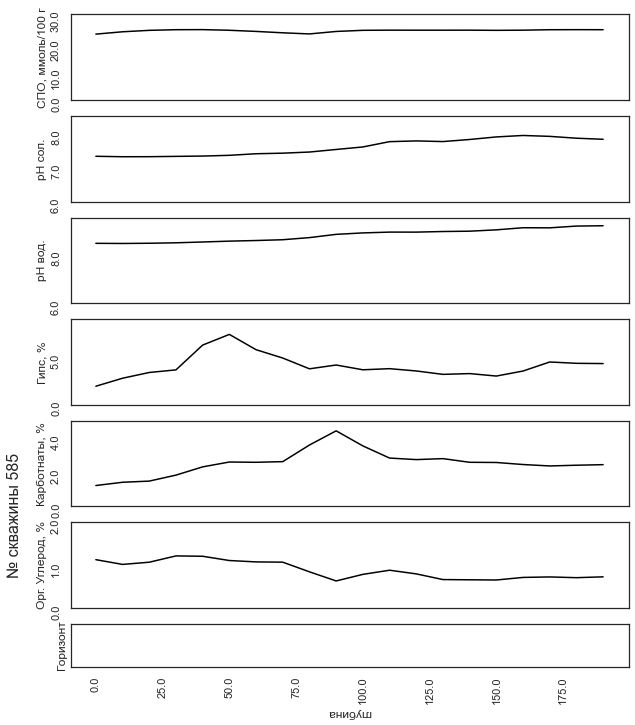

In [20]:

horizonts = ['A',"Bc" , "C"]
depth = [[0,35],[35,100], [100 ,175]]
colors = ["#6E2C00","#BF7F50", "#FFDF29"]

profile_plot(sample,'585'  )

In [21]:
def salt_profile(sample, plot_name):   
    sns.set_theme(style="white", palette=None) 
    kations = ['Массовая доля кальция (водорастворимая форма), ммоль/100 г почвы',
        'Массовая доля магния (водорастворимая форма), ммоль/100 г почвы',
        'Массовая доля натрия (водорастворимая форма), мг•экв на 100 г почвы',
        'Массовая доля калия (водорастворимая форма), мг•экв на 100 г почвы'
    ]
    anions = ['Карбонат и бикарбонат-ионы, ммоль/100 г', 
        'Массовая доля иона хлорида, ммоль/100 г',
        'Массовая доля иона сульфата, ммоль/100 г'
    ]
    sample[anions] = sample[anions] * -1 


    anions.extend(kations)
    salts = anions.copy()
    anions.extend(["Массовая доля плотного остатка водной вытяжки, %", "depth"])
    salt_sample = sample[anions]

    colors = ['#FF0000', "#FFF300", "#13FF00", "#00FFFB","#0000FF","#C500FF", "#FF0068" ]
    labs = ["CO\u2083\u00B2\u207B и HCO\u2083\u207B" , 
    "Cl\u207B",
    "SO\u2084\u00B2\u207B",
    "Ca\u00B2\u207A",
    "Mg\u00B2\u207A",
    "Na\u207A",
    "K\u207A"]
    legend_list = []
    for i in range(len(labs)):
        legend_list.append(mpatches.Patch(color=colors[i], label= labs[i],alpha=0.5))

    hr = {'height_ratios': [ 2,4]}
    fig, ax  = plt.subplots(2,1, figsize = (10,6), gridspec_kw=hr )

    sns.lineplot(y =gaussian_filter1d(salt_sample["Массовая доля плотного остатка водной вытяжки, %"], sigma = 0.75) , x = salt_sample["depth"], color = 'black' ,ci=None, ax = ax[0])
    ax[0].invert_xaxis()
    ax[0].set(xticks=[], xlabel=None, ylabel ='Плотн.ост, %' )
    ax[0].set(ylim=(0, 2), label = '', xlim=(0,200))
    ax[0].set_yticklabels(ax[0].get_yticks(), rotation = 90)


    for num, sal in enumerate(salts):
        sns.lineplot( y =gaussian_filter1d(salt_sample[sal] , sigma = 0.75) , x = salt_sample["depth"] ,color = colors[num], ci=None, ax = ax[1])
        ax[1].fill_between(x =salt_sample["depth"],y1 = 0, y2 = gaussian_filter1d(salt_sample[sal] , sigma = 0.75), color= colors[num], alpha=0.5)

    ax[1].set(ylim=(-5, 5), ylabel ='Концентрация растворимых солей\nммоль/100 г', xlim=(0,200))
    ax[1].axhline(0,color =  "black")
    ax[1].set_xticklabels(ax[-1].get_xticks(), rotation = 90)
    ax[1].set_xlabel('глубина', rotation = 180)
    ax[1].set_yticklabels(ax[1].get_yticks(), rotation = 90)

    ax[-1].set_title('№ скважины {}'.format(plot_name), fontsize = 16, rotation = 90, x = -0.1, y = 2)
    plt.legend(handles=legend_list, title='Растворимые соли', loc='lower left', mode = 'expand',ncol = 3, bbox_to_anchor=(1, 0.5, 0.5, 0.5))
    plt.savefig('{}_соли.png'.format(plot_name))

In [22]:
labs = ["CO\u2083\u00B2\u207B и HCO\u2083\u207B" , 
    "Cl\u207B",
    "SO\u2084\u00B2\u207B",
    "Ca\u00B2\u207A",
    "Mg\u00B2\u207A",
    "Na\u207A",
    "K\u207A"]
labs

['CO₃²⁻ и HCO₃⁻', 'Cl⁻', 'SO₄²⁻', 'Ca²⁺', 'Mg²⁺', 'Na⁺', 'K⁺']

## Физика 

объемный вес

In [23]:
ob_ves = pd.read_csv('полевые данные общая/ready_data/объемный вес.csv')

In [24]:
def ob_ves_plot(ob_ves):
        fig= plt.figure(figsize=(7,5))
        ob_ves_plot = sns.pointplot(data = ob_ves,
                x = "GPS №",
                y = "Объемный вес",
                hue = "GPS №",
                palette = "tab10",
                scale = 1.2,
                ci = 95,
                dodge= 0.5,
                join = False,
                capsize = .05,
        )
        ob_ves_plot.set(title =  'Объемный вес')
        plt.show()

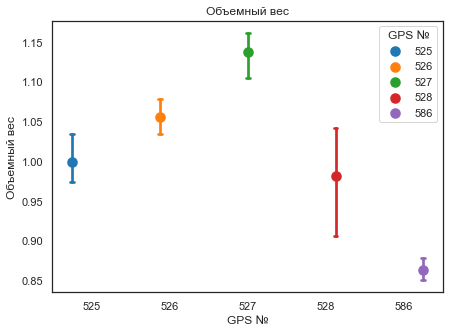

In [25]:
ob_ves_plot(ob_ves)

гран состав

In [26]:
gran_sostav = pd.read_csv('полевые данные общая/ready_data/гранулометрический состав.csv')
sample = gran_sostav[gran_sostav["GPS №"] == 525]

In [27]:
sns.set_theme(font_scale = 14)


In [28]:
def gransostav_plot(sample, plot_name):
    sns.set(rc={ 'figure.facecolor':'white'})
    small_labs = sample.columns[1:7]
    big_labs = sample.columns[7:9]
    fig, ax  = plt.subplots(2,1, figsize = (4,8))

    ax[0].pie(x = sample[big_labs].values.reshape(-1),autopct="%.1f%%",explode=[0.05]  * 2 ,wedgeprops={'edgecolor': 'black'}, labels = big_labs, shadow=True)
    ax[1].pie(x = sample[small_labs].values.reshape(-1),autopct="%.1f%%",explode=[0.05]  * 6 , wedgeprops={'edgecolor': 'black'}, labels = small_labs, shadow=True)
    ax[0].set_title("Гранулометрический состав {}".format(plot_name))

    plt.show()


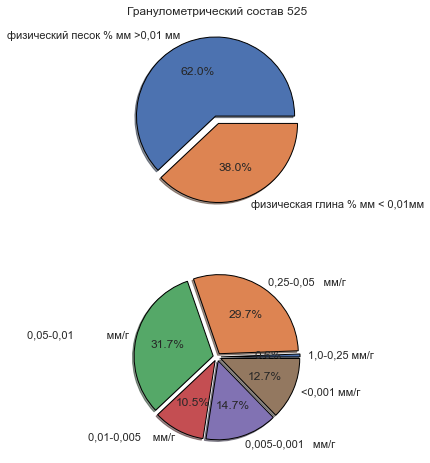

In [29]:
gransostav_plot(sample, '525')

Агрегатный состав и все с ним связанное 


- Глыбистость - % 
- Сумма агрономически - ценных агрегатов 
- СВД мм 
- К.структурности 

Средневзвешенный диаметр - svd = SUM((вес фракции/суммарный вес образца * средний размер агрегата)


http://www.agrophys.ru/Media/Default/JournalAgrophysica/Agrophysika1-2017/full1-2017/Boitsova.PDF лучший варик с интерпретаций данных - АФИ коэф Структурности

In [30]:
agrofiz = pd.read_csv("полевые данные общая/ready_data/агрофизика.csv")

In [31]:
agrofiz.columns

Index(['Год', 'GPS №', 'Тип обработки', 'повторность',
       'Содержание 0,25–10 мм, %', 'Содержание >10, %', 'Содержание <0.25, %',
       'Коэф. структурности', 'СВД, мм', 'Коэф. АФИ',
       'Содержание 0.25–10 мм(водоустойчивые), % ',
       'СВД водоустойчивые 10-7, мм', 'СВД водоустойчивые 5-3, мм',
       'СВД водоустойчивые 7-5, мм', 'СВД водоустойчивые >10, мм'],
      dtype='object')

In [32]:
def agrofiz_plot(data, proprety):
    sns.set(font_scale = 14)

    sns.set_theme(style="white", palette=None)
    fig = plt.figure(figsize=(7,7))
    plot = sns.pointplot(data = data,
                    x = "Тип обработки",
                    y = proprety,
                    hue = "Тип обработки",
                    palette = "prism",
                    scale = 1.2,
                    ci = 95,
                    join = False,
                    capsize = .05,)
    plot.set_title('Сравнение по обработкам')
    plt.show()

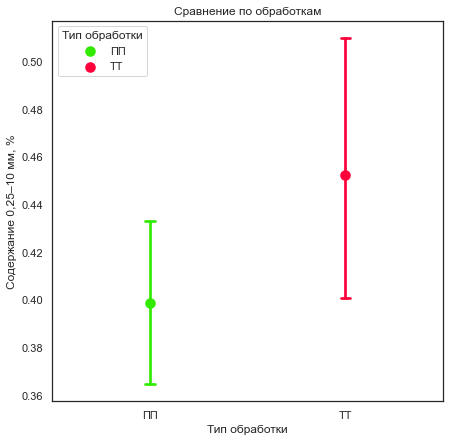

In [33]:
agrofiz_plot(agrofiz,'Содержание 0,25–10 мм, %')

In [34]:
SVD_by_agregates = agrofiz[[
    'Тип обработки',
    'СВД водоустойчивые >10, мм',
    'СВД водоустойчивые 10-7, мм',
    'СВД водоустойчивые 7-5, мм' ,
    'СВД водоустойчивые 5-3, мм']]
SVD_by_agregates = SVD_by_agregates.melt(
    id_vars = 'Тип обработки' ,
    value_vars = [
        'СВД водоустойчивые >10, мм',
        'СВД водоустойчивые 10-7, мм',
        'СВД водоустойчивые 7-5, мм' ,
        'СВД водоустойчивые 5-3, мм']
    , var_name = 'Агрегаты, мм'
    , value_name='Размер, мм')

SVD_by_agregates['Агрегаты, мм'] = SVD_by_agregates['Агрегаты, мм'].str.split(' ', expand=True)[2].str.replace(',','')

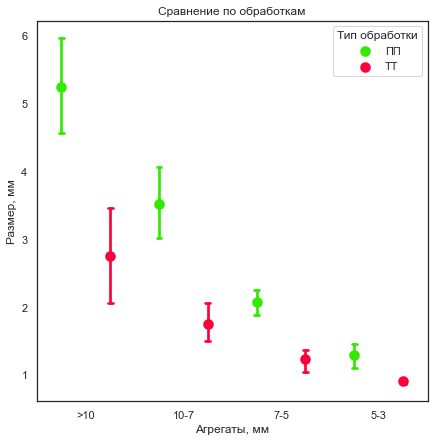

In [35]:
sns.set_theme(style="white", palette=None)
fig = plt.figure(figsize=(7,7))
plot = sns.pointplot(data = SVD_by_agregates,
                x = "Агрегаты, мм",
                y = "Размер, мм",
                hue = "Тип обработки",
                palette = "prism",
                scale = 1.2,
                dodge = 0.5,
                ci = 95,
                join = False,
                capsize = .05,)
plot.set_title('Сравнение по обработкам')
plt.show()

Вот теперь можно сесть и описать это все

# описание скважин

для описания

In [49]:
agrochemistry_total['depth'] = agrochemistry_total["Глубина"].str.split('-', expand=True)[0]
agrochemistry_total['depth'] = agrochemistry_total['depth'].astype(int)
agrochemistry_total = agrochemistry_total.round(2)
agrochemistry_total = agrochemistry_total.drop('Массовая доля общего содержания карбонатов (по Козловскому), %(CaCO3)', axis = 1)

agrochemistry_total = agrochemistry_total[agrochemistry_total['повторность'] == '[0]']

gran_sostav = pd.read_csv('полевые данные общая/ready_data/гранулометрический состав.csv')
gran_sostav["GPS №"] = gran_sostav["GPS №"].astype(str)

KeyError: "['Массовая доля общего содержания карбонатов (по Козловскому), %(CaCO3)'] not found in axis"

In [50]:
agrochemistry_total

,Год,GPS №,Тип обработки,Глубина,повторность,"рН солевой вытяжки, ед. рН","рН водной вытяжки, ед. рН","Фосфор (подвижная форма), мг/кг","Калий (подвижная форма), млн-1","Общий азот, %",...,"Массовая доля магния (водорастворимая форма), ммоль/100 г почвы","Массовая доля кальция (водорастворимая форма), ммоль/100 г почвы","Массовая доля натрия (водорастворимая форма), мг•экв на 100 г почвы","Массовая доля калия (водорастворимая форма), мг•экв на 100 г почвы","Сумма поглощенных оснований по Каппену, ммоль/100 г","Массовая доля плотного остатка водной вытяжки, %","Карбонат и бикарбонат-ионы, ммоль/100 г","Массовая доля общего содержания карбонатов (по Козловскому), % (CO2)","Органический углерод, %",depth
0,2021,584,ТТ,0-10,[0],6.69,8.73,23.40,366.27,0.13,...,0.09,0.37,0.00,0.00,24.700000000000003,0.09,0.03,1.31,1.34,0
1,2021,584,ТТ,10-20,[0],6.73,8.71,21.00,332.80,0.13,...,0.09,0.33,0.00,0.00,24.55,0.07,0.03,1.54,1.25,10
2,2021,584,ТТ,20-30,[0],6.81,8.91,12.60,283.75,0.10,...,0.10,0.39,0.00,0.00,24.6,0.11,0.03,1.80,1.03,20
3,2021,584,ТТ,30-40,[0],6.87,8.66,8.40,214.49,0.09,...,0.12,0.34,0.00,0.00,24.55,0.06,0.03,2.99,0.67,30
4,2021,584,ТТ,40-50,[0],6.87,8.77,7.40,200.28,0.08,...,0.10,0.32,0.00,0.00,24.65,0.07,0.03,2.40,0.77,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,2020,529,ТТ,150-160,[0],7.33,8.87,3.37,119.43,0.03,...,0.50,0.75,0.31,0.02,24.169741697416978,0.18,0.80,2.31,0.78,150
216,2020,529,ТТ,160-170,[0],7.82,9.07,2.87,96.44,0.03,...,0.55,0.40,0.44,0.02,24.07749077490775,0.16,0.80,2.66,0.77,160
217,2020,529,ТТ,170-180,[0],7.92,8.96,3.86,94.65,0.03,...,0.10,0.40,0.66,0.02,23.523985239852397,0.21,1.00,2.53,0.77,170
218,2020,529,ТТ,180-190,[0],7.90,8.93,4.35,92.96,0.03,...,0.50,0.30,0.89,0.02,24.169741697416978,0.21,0.95,2.38,0.82,180


In [79]:

def profile_plot(sample,plot_name , horizonts = None,depth = None, colors = None, ):
    sns.set_theme(style="white", palette=None)
    agrochem_features =[
    "Сумма поглощенных оснований по Каппену, ммоль/100 г",
    'М.д. содержания  гипса (по Хитрову), %',
    'Массовая доля общего содержания карбонатов (по Козловскому), % (CO2)',
    'Органический углерод, %'
    ]

    agrochem_features_labs = [
        "СПО, ммоль/100 г",
        "Гипс, %",
        "Карботнаты, %",
        "Орг. Углерод, %" ]
    limits = [
        (20,30),
        (0,9), 
        (0,5),
        (0,2)

    ]
    hr = {'height_ratios': [ 2,4,2,2,2,2,1]}
    
    fig, ax  = plt.subplots(7,1, figsize = (10,15), gridspec_kw=hr )

    profile = sns.lineplot(data =sample, y ='Органический углерод, %' , x = "depth" ,alpha = 0,ci=None, ax = ax[-1])
    ax[-1].set( ylabel ='Горизонт', yticks =[], xlim=(0,200)  )
    ax[-1].set_xticklabels(ax[-1].get_xticks(), rotation = 90)
    ax[-1].set_xlabel('глубина', rotation = 180)
    ax[-1].set_title('№ скважины {}'.format(plot_name), fontsize = 16, rotation = 90, x = -0.1, y = 2)
    


    if horizonts != None:
        for hor in range(len(horizonts)):
            ax[-1].fill_between(x =depth[hor],y1 = 2, color=colors[hor],  hatch = ['+'])
            text_position = (depth[hor][1] - depth[hor][0])/2 + depth[hor][0]
            ax[-1].text(x = text_position , y = 0.6, s = horizonts[hor],size = 16,weight='bold' , rotation = 90)
            ax[-1].axvline(depth[hor][1],color =  "black", alpha = 0.5, linestyle = "--")

    ax_num = [2,3,4,5]
    for num, prop in enumerate(agrochem_features):

        property = gaussian_filter1d(sample[prop].astype('float'), sigma = 0.75)
        sns.lineplot(y = property , x = sample["depth"] ,color = 'black', ci=None, ax = ax[ax_num[num]])
        ax[ax_num[num]].set(xticks =[], xlabel=None, ylabel =agrochem_features_labs[num] , ylim=limits[num], xlim=(0,200))
        ax[ax_num[num]].set_yticklabels(ax[ax_num[num]].get_yticks(), rotation = 90)
        if horizonts != None:
            for line in depth:
               ax[ax_num[num]].axvline(line[1],color =  "black", alpha = 0.5, linestyle = "--")

    #соли

    kations = ['Массовая доля кальция (водорастворимая форма), ммоль/100 г почвы',
        'Массовая доля магния (водорастворимая форма), ммоль/100 г почвы',
        'Массовая доля натрия (водорастворимая форма), мг•экв на 100 г почвы',
        'Массовая доля калия (водорастворимая форма), мг•экв на 100 г почвы'
    ]
    anions = ['Карбонат и бикарбонат-ионы, ммоль/100 г', 
        'Массовая доля иона хлорида, ммоль/100 г',
        'Массовая доля иона сульфата, ммоль/100 г'
    ]
    sample[anions] = sample[anions] * -1 


    anions.extend(kations)
    salts = anions.copy()
    anions.extend(["Массовая доля плотного остатка водной вытяжки, %", "depth"])
    salt_sample = sample[anions]

    colors = ['#FF0000', "#FFF300", "#13FF00", "#00FFFB","#0000FF","#C500FF", "#FF0068" ]
    labs = ["CO\u2083\u00B2\u207B и HCO\u2083\u207B" , 
    "Cl\u207B",
    "SO\u2084\u00B2\u207B",
    "Ca\u00B2\u207A",
    "Mg\u00B2\u207A",
    "Na\u207A",
    "K\u207A"]
    legend_list = []
    for i in range(len(labs)):
        legend_list.append(mpatches.Patch(color=colors[i], label= labs[i],alpha=0.5))


    sns.lineplot(y =gaussian_filter1d(salt_sample["Массовая доля плотного остатка водной вытяжки, %"], sigma = 0.75) , x = salt_sample["depth"], color = 'black' ,ci=None, ax = ax[0])
    ax[0].invert_xaxis()
    ax[0].set(xticks=[], xlabel=None, ylabel ='Плотн.ост, %' )
    ax[0].set(ylim=(0, 2), label = '', xlim=(0,200))
    ax[0].set_yticklabels(ax[0].get_yticks(), rotation = 90)

    for line in depth:
        ax[0].axvline(line[1],color =  "black", alpha = 0.5, linestyle = "--")


    for num, sal in enumerate(salts):
        sns.lineplot( y =gaussian_filter1d(salt_sample[sal] , sigma = 0.75) , x = salt_sample["depth"] ,color = colors[num], ci=None, ax = ax[1])
        ax[1].fill_between(x =salt_sample["depth"],y1 = 0, y2 = gaussian_filter1d(salt_sample[sal] , sigma = 0.75), color= colors[num], alpha=0.5)

    ax[1].set(ylim=(-5, 5), ylabel ='Концентрация растворимых солей\nммоль/100 г', xlim=(0,200))
    ax[1].axhline(0,color =  "black")
    ax[1].set(xticks =[])
    ax[1].set_xlabel('', rotation = 180)
    ax[1].set_yticklabels(ax[1].get_yticks(), rotation = 90)
    for line in depth:
        ax[1].axvline(line[1],color =  "black", alpha = 0.5, linestyle = "--")

    ax[-1].set_title('№ скважины {}'.format(plot_name), fontsize = 16, rotation = 90, x = -0.1, y = 2)
    plt.legend(handles=legend_list, title='Растворимые соли', loc='lower left', mode = 'expand',ncol = 3, bbox_to_anchor=(1, 0.5, 0.5, 0.5))


    plt.savefig('{}_профиль.png'.format(plot_name))

In [80]:
colors

['#675434', '#825925', '#996B2F', '#FFE874']

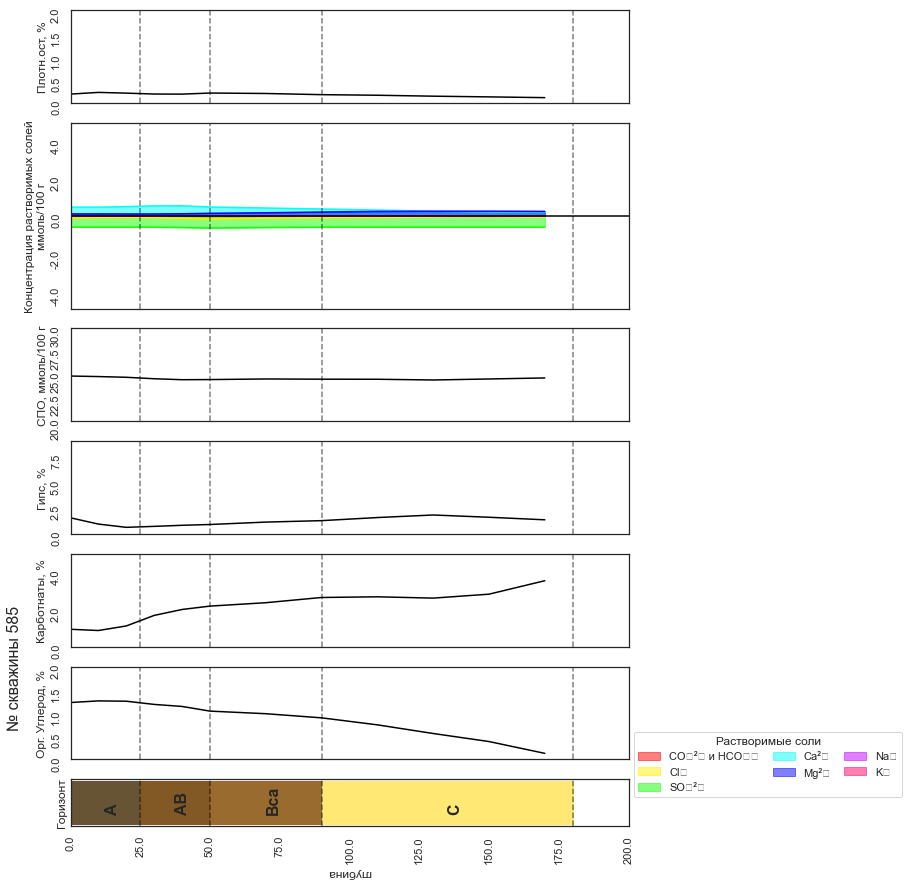

In [81]:
horizonts = ['A',"AB" , "Bca",'C']
depth = [[0,25],[25,50], [50 ,90],[90,180]]
colors =["#675434","#825925","#996B2F", "#FFE874"]
profile_plot(agrochemistry_total[agrochemistry_total["GPS №"] == '585'], '585' , horizonts, depth, colors)

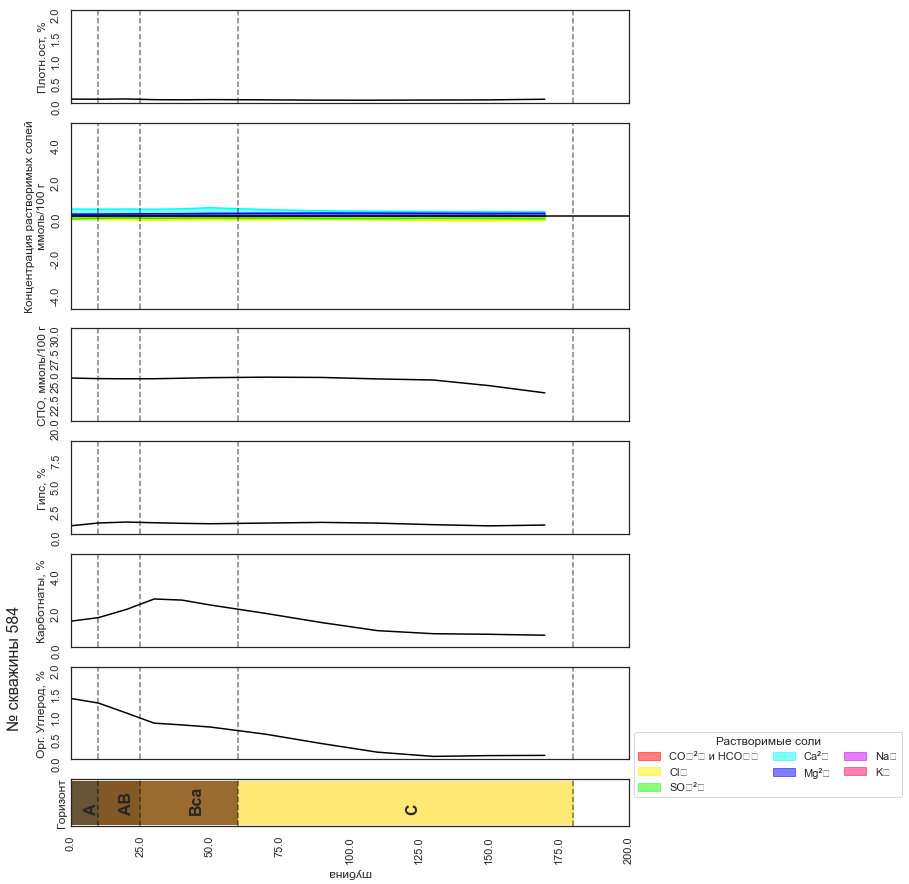

In [82]:
horizonts = ['A',"AB" , "Bca",'C']
depth = [[0,10],[10,25], [25 ,60],[60,180]]
colors =["#675434","#825925","#996B2F", "#FFE874"]
profile_plot(agrochemistry_total[agrochemistry_total["GPS №"] == '584'], '584' , horizonts, depth, colors)


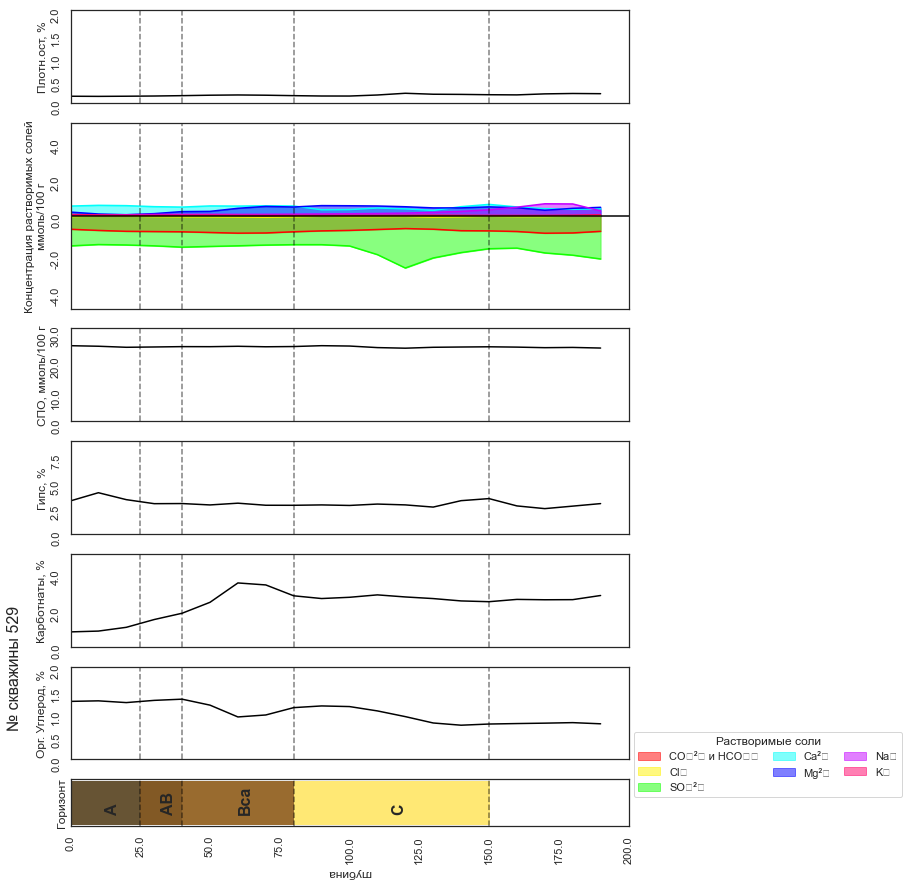

In [74]:
horizonts = ['A',"AB" , "Bca",'C']
depth = [[0,25],[25,40], [40 ,80],[80,150]]
colors =["#675434","#825925","#996B2F", "#FFE874"]
profile_plot(agrochemistry_total[agrochemistry_total["GPS №"] == '529'], '529' , horizonts, depth, colors)


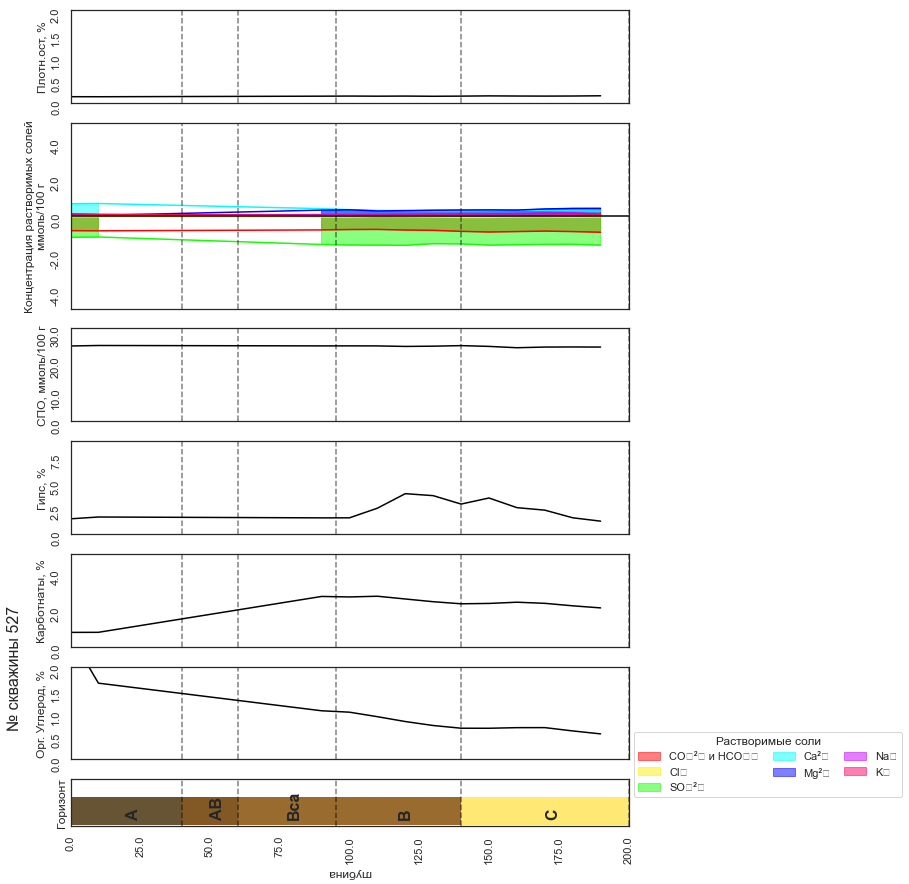

In [75]:
horizonts = ['A',"AB" , "Bca",'B','C']
depth = [[0,40],[40,60], [60 ,95],[95,140],[140,200]]
colors =["#675434","#825925","#996B2F","#996B2F", "#FFE874"]

profile_plot(agrochemistry_total[agrochemistry_total["GPS №"] == '527'], '527' , horizonts, depth, colors)

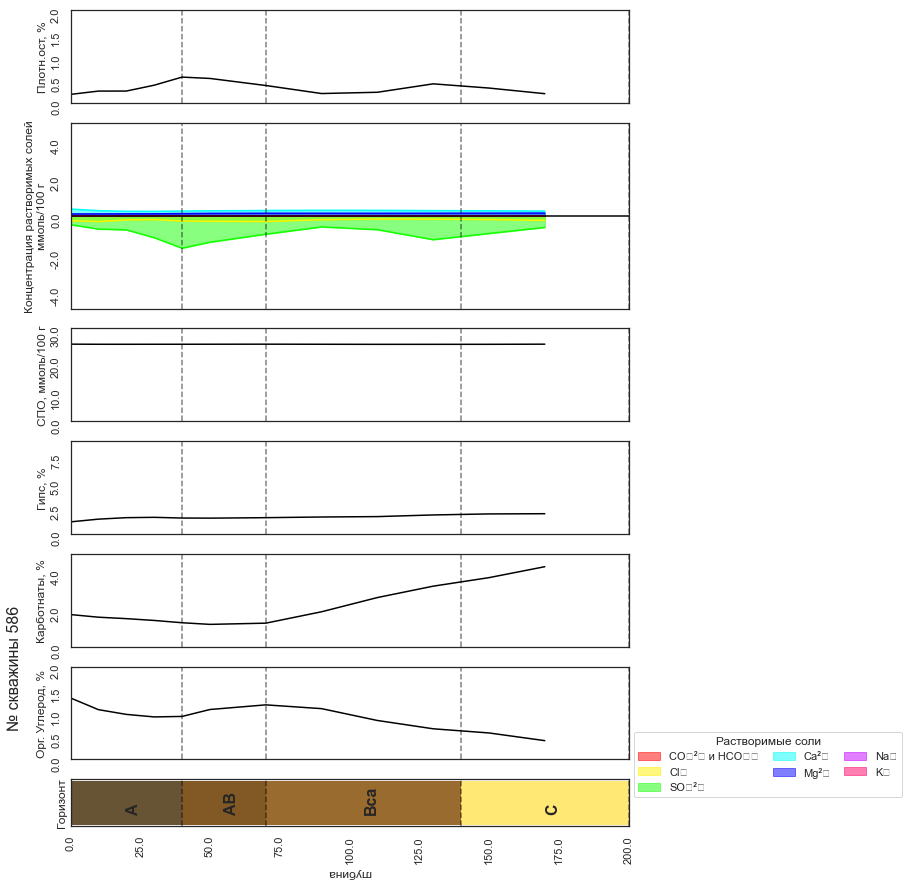

In [76]:
horizonts = ['A',"AB" , "Bca",'C']
depth = [[0,40],[40,70], [70 ,140],[140,200]]
colors =["#675434","#825925","#996B2F", "#FFE874"]

profile_plot(agrochemistry_total[agrochemistry_total["GPS №"] == '586'], '586' , horizonts, depth, colors)

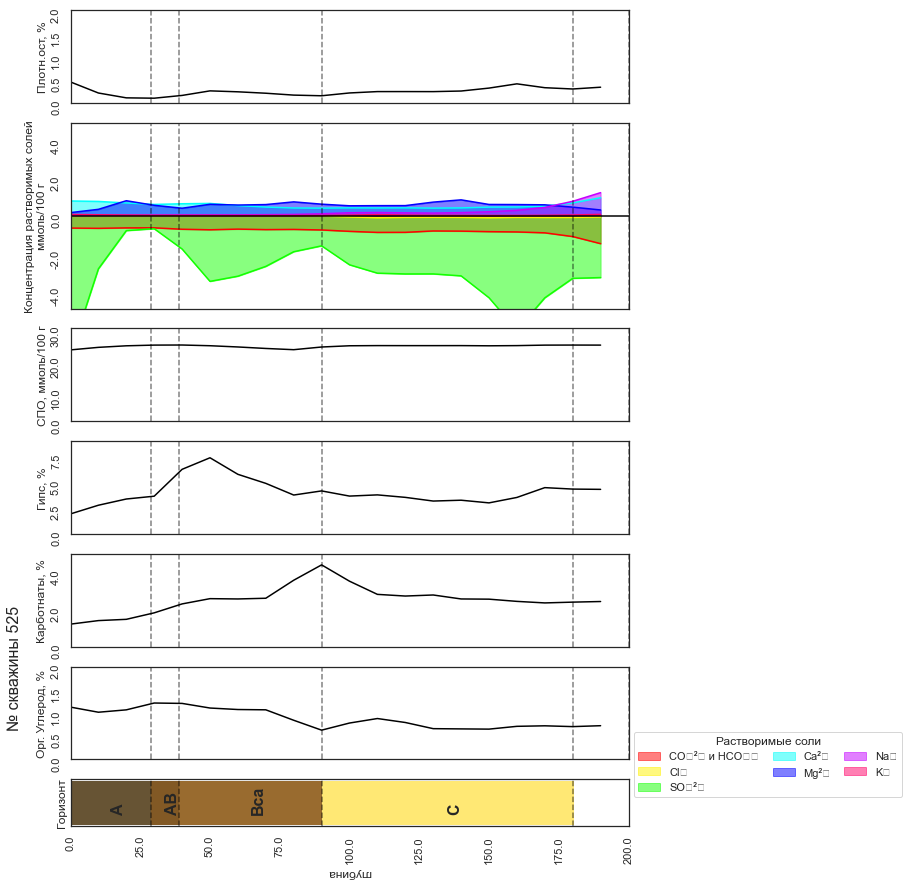

In [77]:
horizonts = ['A',"AB" , "Bca",'C']
depth = [[0,29],[29,39], [39 ,90],[90,180],[150,200]]
colors =["#675434","#825925","#996B2F", "#FFE874"]

profile_plot(agrochemistry_total[agrochemistry_total["GPS №"] == '525'], '525' , horizonts, depth, colors)

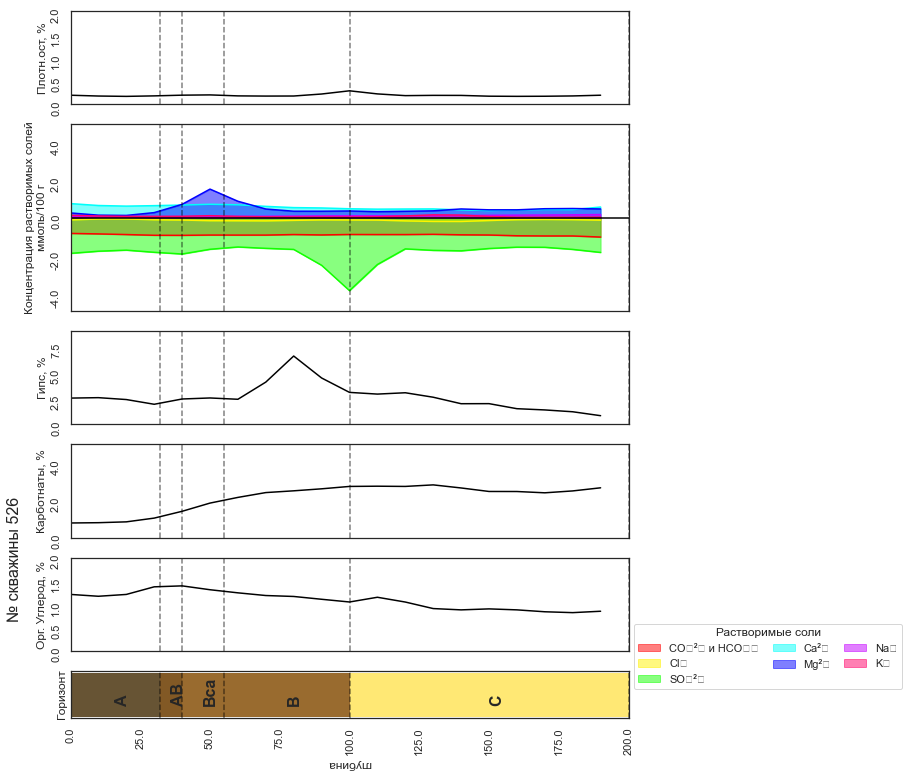

In [45]:
horizonts = ['A',"AB" , "Bca",'B','C']
depth = [[0,32],[32,40], [40 ,55],[55,100],[100,200]]
colors =["#675434","#825925","#996B2F","#996B2F", "#FFE874"]

profile_plot(agrochemistry_total[agrochemistry_total["GPS №"] == '526'], '526' , horizonts, depth, colors)

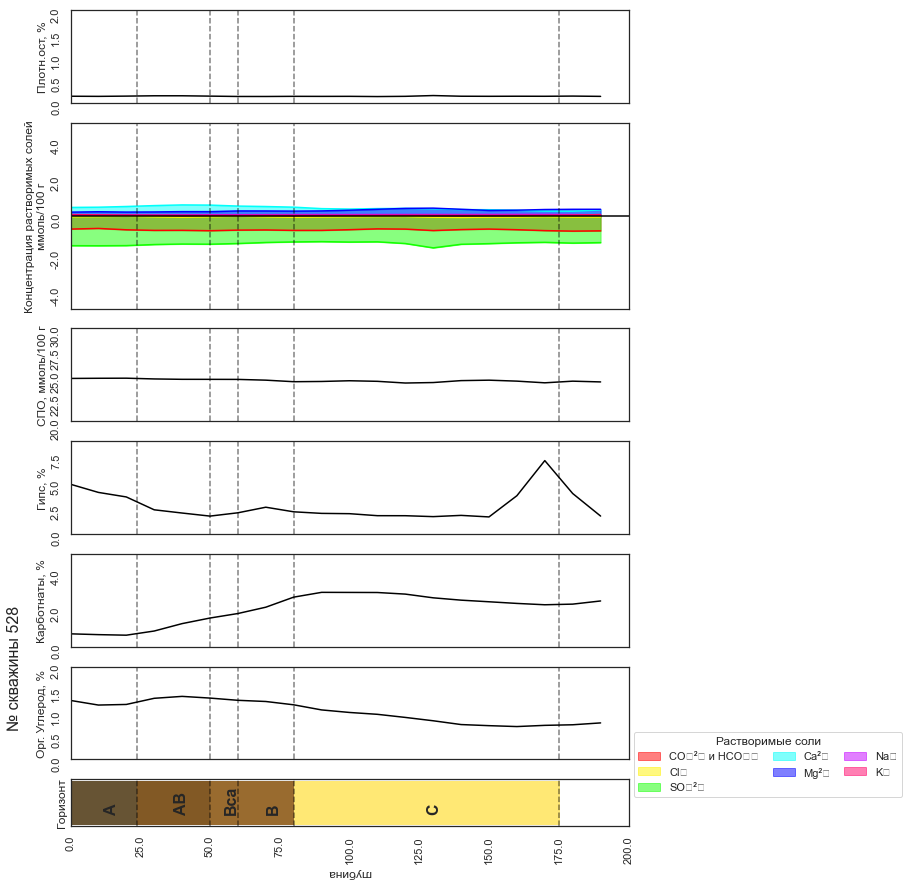

In [84]:
horizonts = ['A',"AB" , "Bca",'B','C']
colors =["#675434","#825925","#996B2F","#996B2F", "#FFE874"]

depth = [[0,24],[24,50], [50 ,60],[60,80],[80,175]]
profile_plot(agrochemistry_total[agrochemistry_total["GPS №"] == '528'], '528' , horizonts, depth, colors)

In [47]:
agrochemistry_main.groupby(['Тип обработки'] ).std()

,GPS №,"рН солевой вытяжки, ед. рН","рН водной вытяжки, ед. рН","Фосфор (подвижная форма), мг/кг","Калий (подвижная форма), млн-1","Общий азот, %","Органический углерод, %"
Тип обработки,,,,,,,
ПП,42.508659,0.096106,0.186779,11.823894,138.912548,0.035758,0.371264
ТТ,53.634465,0.191123,0.265039,8.791836,66.989335,0.029472,0.192652


In [48]:
agrochemistry_main

,Год,GPS №,Тип обработки,Глубина,"рН солевой вытяжки, ед. рН","рН водной вытяжки, ед. рН","Фосфор (подвижная форма), мг/кг","Калий (подвижная форма), млн-1","Общий азот, %","Органический углерод, %"
0,2021,584,ТТ,0-10,6.69,8.73,23.40,366.273656,0.13,1.340100
1,2021,584,ТТ,10-20,6.73,8.71,21.00,332.802456,0.13,1.249600
2,2021,584,ТТ,20-30,6.81,8.91,12.60,283.751496,0.10,1.026000
12,2021,584,ТТ,0-10,7.18,8.55,23.60,339.881976,0.13,1.068100
13,2021,584,ТТ,10-20,7.20,8.58,15.40,324.326296,0.13,1.116200
...,...,...,...,...,...,...,...,...,...,...
255,2019,452,ТТ,10-20,7.39,8.76,17.98,235.560000,0.14,1.289991
256,2019,453,ТТ,10-20,7.40,8.64,14.81,206.600000,0.13,1.251809
257,2019,454,ТТ,10-20,7.33,8.37,56.58,446.890000,0.17,1.430545
258,2019,455,ТТ,10-20,7.31,8.39,12.69,224.640000,0.11,1.032091
